In [1]:
!python --version

Python 3.9.16


### **Bibliotecas**

In [2]:
import pandas as pd
import numpy as np
from utils.utils import select_best_features, ClipTransformer, plot_roc_curve, plot_precision_recall_curve, plot_mean_by_category, plot_stacked_bar_chart
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report,accuracy_score
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

### **Análise Exploratória**

In [3]:
# Carregando os dados
df_original = pd.read_csv("dados/base_modelo.csv", index_col="id")
df_original.sample(5)

,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,...,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
id,,,,,,,,,,,,,,,,,,,,,
2356,201403,1,148.0,2.0,1.0,1.0,265.24,831.0,97.99,155.70,...,257.87,NaN,0.0,4.0,0.0,0.0,1137.09,467.87,0.0,0.0
3913,201403,0,21.0,0.0,0.0,0.0,NaN,258.0,22.49,NaN,...,NaN,NaN,NaN,258.0,NaN,NaN,NaN,NaN,NaN,NaN
1980,201412,1,16.0,0.0,0.0,0.0,NaN,213.0,59.97,NaN,...,NaN,NaN,NaN,115.0,NaN,NaN,NaN,NaN,NaN,NaN
2767,201403,0,15.0,0.0,0.0,0.0,NaN,223.0,NaN,55.97,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6530,201405,0,0.0,0.0,0.0,0.0,37.98,701.0,NaN,NaN,...,NaN,NaN,NaN,145.0,NaN,NaN,NaN,126.41,NaN,NaN


In [4]:
# Conferindo shape do conjunto
df_original.shape

(10738, 80)

In [5]:
# Conferindo se todos os ID"s são distintos
df_original.index.nunique()

10738

In [6]:
# Quantidade de registros por classe da target
df_group_y = df_original["y"].value_counts().reset_index()
df_group_y.columns = ["y", "registros"]
df_group_y["representatividade"] = (df_group_y["registros"] / df_original.shape[0]) * 100
df_group_y

,y,registros,representatividade
0,0,7610,70.869808
1,1,3128,29.130192


In [7]:
# Safras Disponíveis e Representatividade
df_group_safra = df_original["safra"].value_counts().reset_index()
df_group_safra.columns = ["safra", "registros"]
df_group_safra = df_group_safra.sort_values("safra").reset_index().drop(columns=["index"])
df_group_safra["representatividade"] = (df_group_safra["registros"] / df_original.shape[0]) * 100
df_group_safra["representativiade_acumulada"] = df_group_safra["representatividade"].cumsum()
df_group_safra

,safra,registros,representatividade,representativiade_acumulada
0,201401,854,7.953064,7.953064
1,201402,898,8.362824,16.315888
2,201403,873,8.130006,24.445893
3,201404,955,8.893649,33.339542
4,201405,972,9.051965,42.391507
5,201406,902,8.400075,50.791581
6,201407,968,9.014714,59.806295
7,201408,912,8.493202,68.299497
8,201409,877,8.167256,76.466754
9,201410,933,8.688769,85.155522


In [8]:
# Verificando dados textuais e numéricos (-1 é para tirar a target)
quantidade_textuais = df_original.select_dtypes("object").shape[1]
quantidade_numericos = df_original.select_dtypes(exclude=["object"]).shape[1] - 1
print("Quantidade de dados textuais: %d" % quantidade_textuais)
print("Quantidade de dados numéricos: %d" % quantidade_numericos)

Quantidade de dados textuais: 0
Quantidade de dados numéricos: 79


In [9]:
# Verificando se há valores duplicados
df_original.duplicated().sum()

0

In [10]:
# Verificando presença de valores nulos
df_original.isnull().sum()[df_original.isnull().sum() > 0]

VAR_1      416
VAR_2      416
VAR_3      416
VAR_4      416
VAR_5     4060
          ... 
VAR_74    5541
VAR_75    7024
VAR_76    4551
VAR_77    5565
VAR_78    5541
Length: 72, dtype: int64

In [11]:
# Features Potenciais Categóricas e numéricas
features_categoricas = [x for x in list(df_original.nunique()[df_original.nunique() <= 10].index) if x not in ["safra","y"]]
features_numericas = [x for x in df_original.columns if x not in features_categoricas + ["safra","y"]]

In [12]:
print(features_categoricas)

['VAR_20', 'VAR_32', 'VAR_64']


### **Dividindo Conjunto**

Estratégia adotadata para divisão: Out of Time

In [13]:
# Separando dados
df_train = df_original[df_original["safra"] <= 201409].drop(columns=["y","safra"]).copy()
#df_train = df_train.reset_index().drop(columns=["id"])
y_train = df_original[df_original["safra"] <= 201409]["y"].copy()
#y_train = y_train.reset_index().drop(columns=["id"])

df_test = df_original[df_original["safra"].between(201410,201412)].drop(columns=["y","safra"]).copy()
#df_test = df_test.reset_index().drop(columns=["id"])
y_test = df_original[df_original["safra"].between(201410,201412)]["y"].copy()
#y_test = y_test.reset_index().drop(columns=["id"])

In [14]:
# Quantidade de registros por classe da target - Treino
df_train_y = y_train.value_counts().reset_index()
df_train_y.columns = ["y", "registros"]
df_train_y["representatividade"] = (df_train_y["registros"] / y_train.shape[0]) * 100
df_train_y

,y,registros,representatividade
0,0,5895,71.793935
1,1,2316,28.206065


In [15]:
# Quantidade de registros por classe da target - Teste
df_test_y = y_test.value_counts().reset_index()
df_test_y.columns = ["y", "registros"]
df_test_y["representatividade"] = (df_test_y["registros"] / df_test.shape[0]) * 100
df_test_y

,y,registros,representatividade
0,0,1715,67.867036
1,1,812,32.132964


### **Feature Selection**

In [16]:
# Preparando DataFrame para selecionar
y_train_copy = y_train.copy()
x_train_copy = df_train.copy()

# Preenchendo valores nulos apenas para testar
imputer_numericas = SimpleImputer(strategy="median")
imputer_categoricas = SimpleImputer(strategy="most_frequent")

# Aplicar o fit_transform aos dados
x_train_copy[features_numericas] = imputer_numericas.fit_transform(x_train_copy[features_numericas])
x_train_copy[features_categoricas] = imputer_categoricas.fit_transform(x_train_copy[features_categoricas])

In [17]:
# Gerando o DataFrame com as melhores features
df_selected = select_best_features(x_train_copy, y_train, 10)

In [18]:
df_selected

,Feature,Permutation Importance,Mutual Information,Spearman Correlation,Pearson Correlation,Kendall Correlation
0,VAR_1,0.025320,0.075274,0.326289,0.394406,0.277422
1,VAR_2,0.004747,0.056487,0.345431,0.256637,0.337280
2,VAR_3,-0.002800,0.052395,0.333355,0.197381,0.326878
3,VAR_4,-0.000122,0.052490,0.295632,0.174722,0.282428
4,VAR_5,-0.000122,0.001920,0.002364,0.012392,0.002027
5,VAR_6,-0.001461,0.010317,0.183374,0.037497,0.149771
6,VAR_7,-0.001339,0.000000,0.022458,0.017884,0.019425
7,VAR_8,-0.000974,0.000000,0.037969,0.031466,0.033045
8,VAR_9,0.001826,0.012832,0.127802,0.119101,0.107417
9,VAR_10,-0.000243,0.017425,0.004560,0.035311,0.004044


In [19]:
selected_features = df_selected["Feature"].values.tolist()
df_train[selected_features]

,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,VAR_10,...,VAR_12,VAR_14,VAR_15,VAR_17,VAR_20,VAR_21,VAR_27,VAR_30,VAR_31,VAR_39
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,124.54,3277.0,51.98,NaN,500.00,153.0,...,299.0,1024.0,26.98,3000.0,8,1279.0,NaN,500.00,22.0,348.0
2,64.0,0.0,2.0,1.0,47.92,2443.0,84.72,NaN,1000.00,649.0,...,224.0,NaN,NaN,NaN,12,1063.0,842.0,1000.00,14.0,179.0
3,99.0,2.0,2.0,2.0,80.38,1824.0,26.63,NaN,1893.35,346.0,...,106.0,NaN,73.55,NaN,12,116.0,597.0,1893.35,NaN,NaN
5,0.0,0.0,0.0,0.0,70.46,437.0,40.69,10.99,2000.00,NaN,...,NaN,288.0,29.58,NaN,12,NaN,NaN,2000.00,0.0,NaN
6,61.0,0.0,4.0,1.0,NaN,140.0,39.83,55.31,400.00,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,400.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,44.0,0.0,0.0,1.0,107.49,515.0,183.36,49.70,500.00,NaN,...,NaN,NaN,50.98,NaN,10,NaN,NaN,500.00,NaN,NaN
10735,0.0,0.0,0.0,0.0,39.98,1029.0,NaN,NaN,1724.65,141.0,...,91.0,342.0,NaN,NaN,12,NaN,NaN,1724.65,0.0,NaN
10736,169.0,3.0,1.0,2.0,105.08,819.0,49.28,74.20,2759.03,260.0,...,NaN,399.0,37.58,2000.0,12,NaN,NaN,2759.03,0.0,418.0


### **Multicolinearidade**

<Axes: >

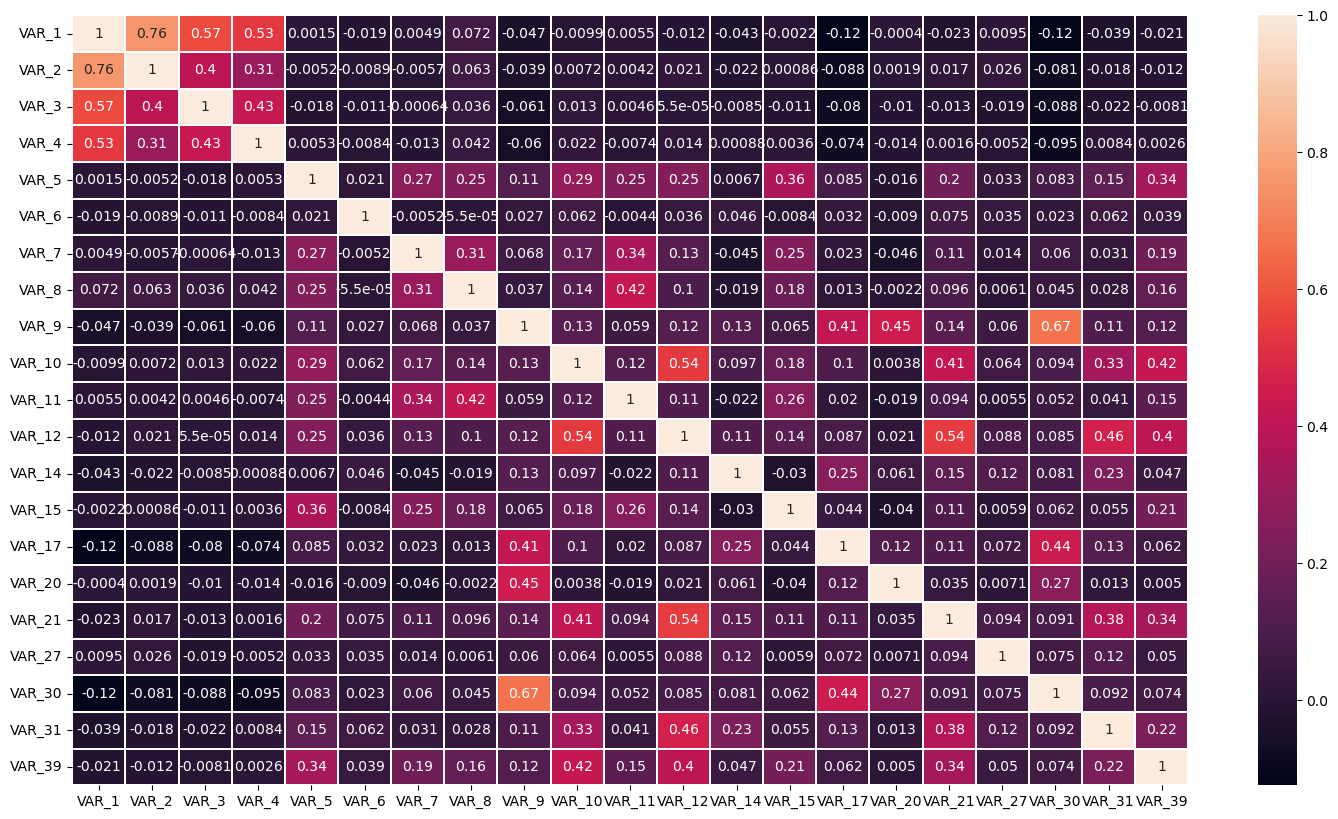

In [20]:
#matriz de correlação de Pearson
pearson_corr = x_train_copy[selected_features].corr()
plt.figure(figsize=(18,10))
sns.heatmap(pearson_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

<Axes: >

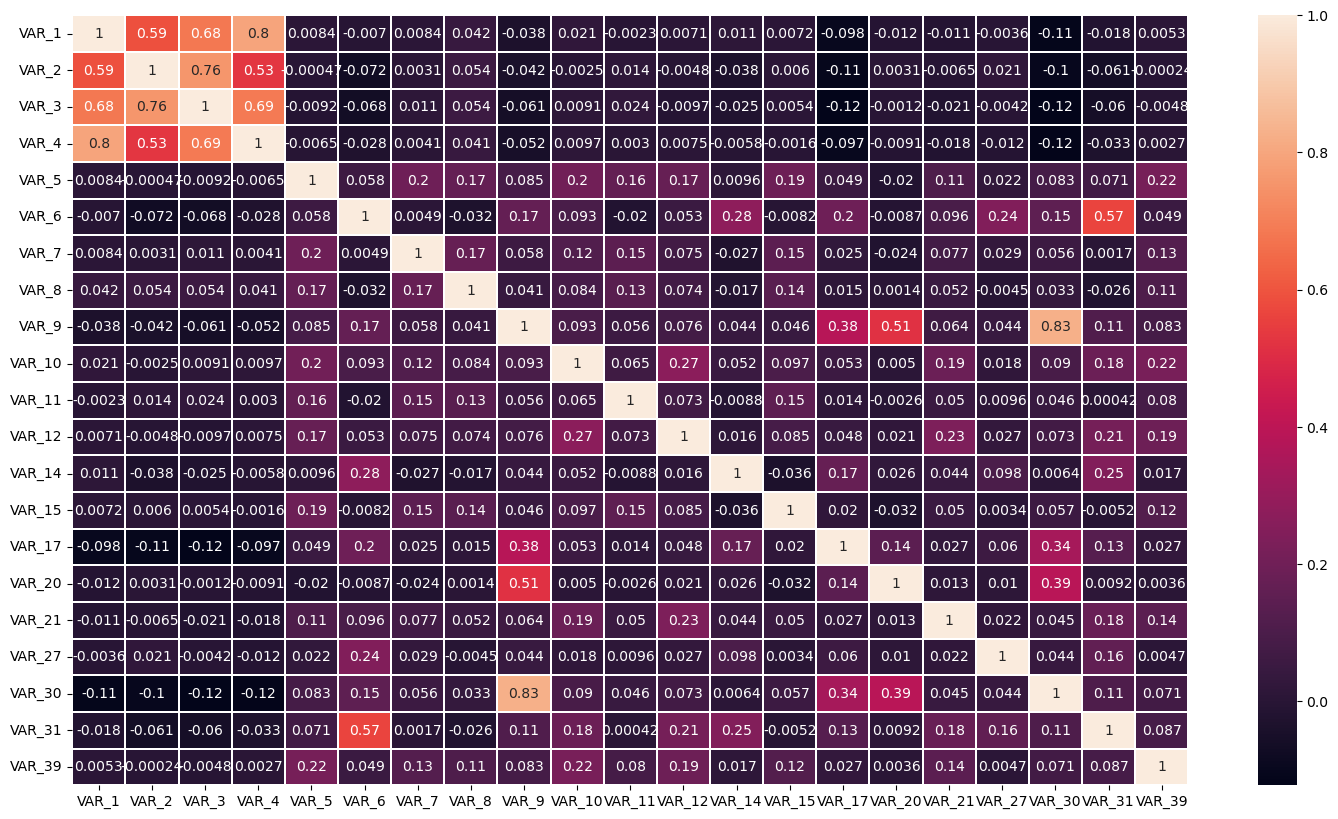

In [21]:
#matriz de correlação de Spearman
spearman_corr = x_train_copy[selected_features].corr(method="spearman")
plt.figure(figsize=(18,10))
sns.heatmap(spearman_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

<Axes: >

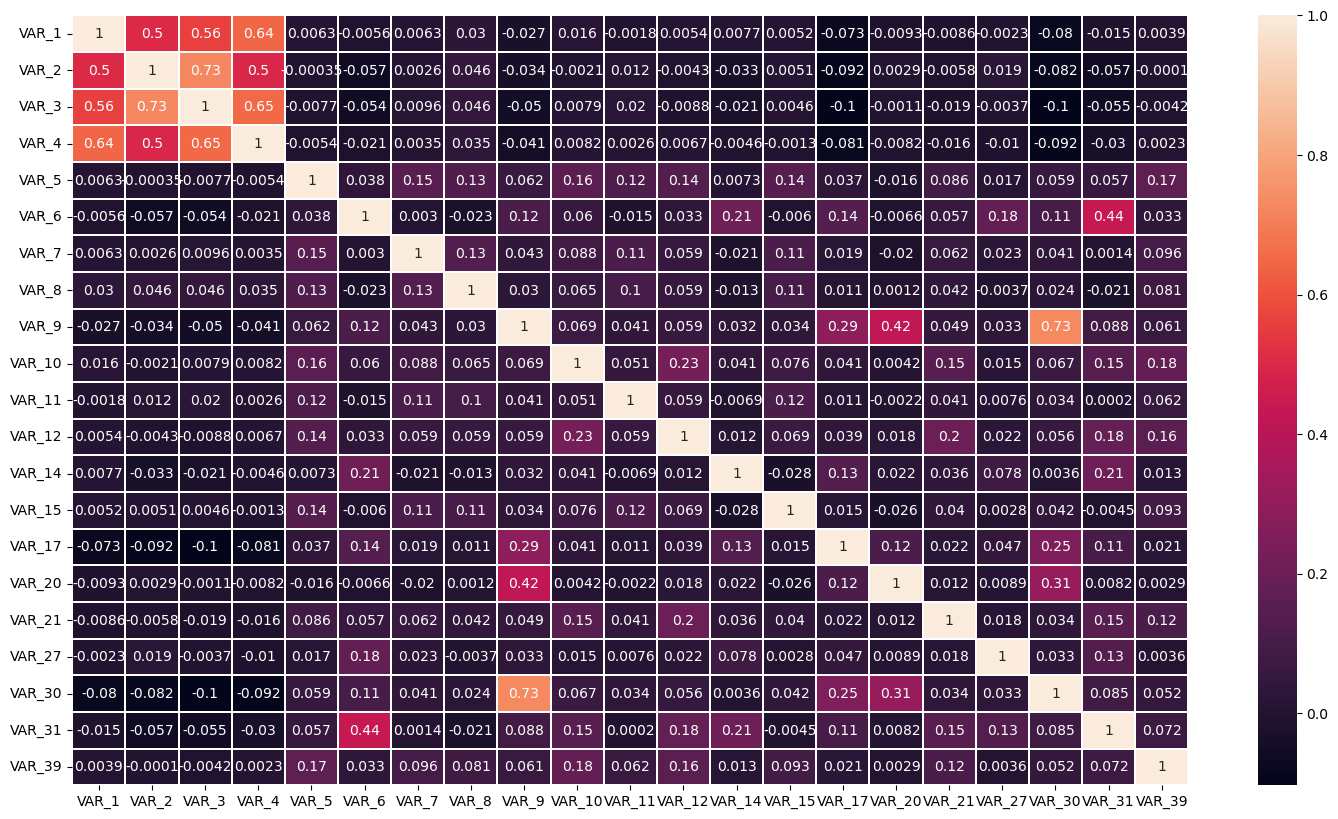

In [22]:
#matriz de correlação de Kendall
kendall_corr = x_train_copy[selected_features].corr(method="kendall")
plt.figure(figsize=(18,10))
sns.heatmap(kendall_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

In [23]:
# Removendo as features com multicolinearidade
# Serão mantidas as vars com maior correlação com a target
multicol_vars = ["VAR_2", "VAR_3", "VAR_4", "VAR_9", "VAR_10", "VAR_11", "VAR_12", "VAR_17", "VAR_31"]
for var in multicol_vars:
    selected_features.remove(var)

<Axes: >

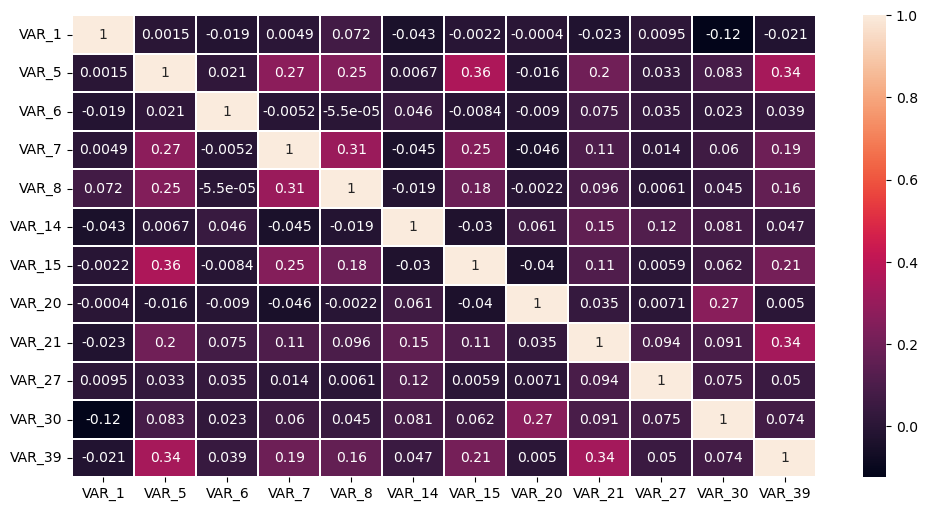

In [24]:
#matriz de correlação de Pearson
pearson_corr = x_train_copy[selected_features].corr()
plt.figure(figsize=(12,6))
sns.heatmap(pearson_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

<Axes: >

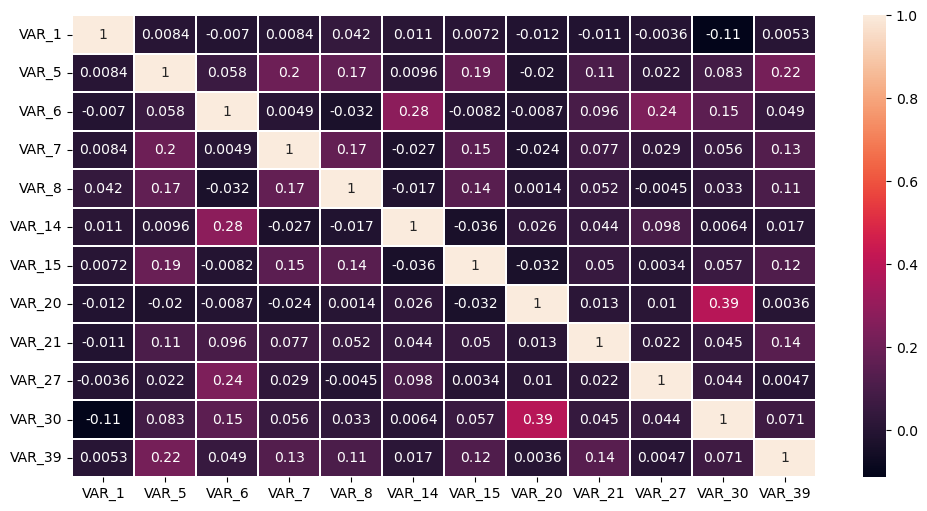

In [25]:
#matriz de correlação de Spearman
spearman_corr = x_train_copy[selected_features].corr(method="spearman")
plt.figure(figsize=(12,6))
sns.heatmap(spearman_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

<Axes: >

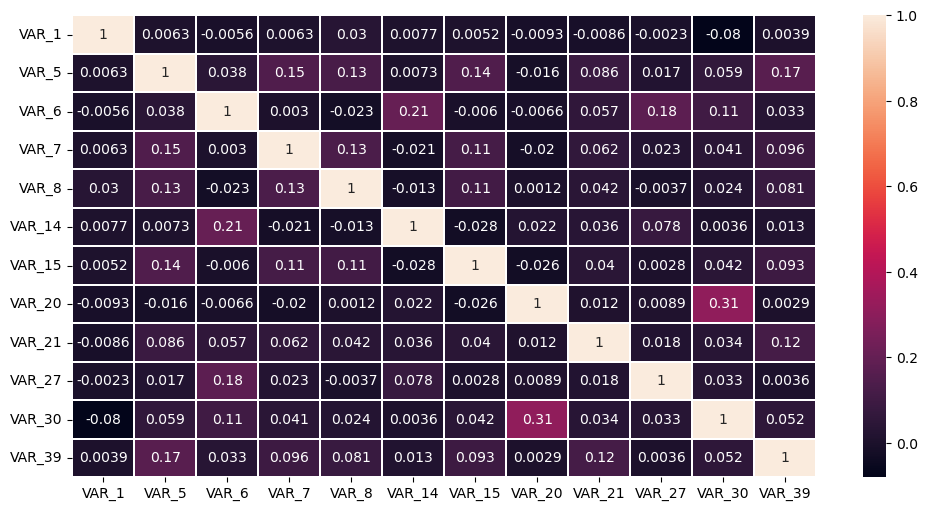

In [26]:
#matriz de correlação de Spearman
kendall_corr = x_train_copy[selected_features].corr(method="kendall")
plt.figure(figsize=(12,6))
sns.heatmap(kendall_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

### **Análise das features selecionadas**

In [27]:
df_train[selected_features]

,VAR_1,VAR_5,VAR_6,VAR_7,VAR_8,VAR_14,VAR_15,VAR_20,VAR_21,VAR_27,VAR_30,VAR_39
id,,,,,,,,,,,,
1,0.0,124.54,3277.0,51.98,NaN,1024.0,26.98,8,1279.0,NaN,500.00,348.0
2,64.0,47.92,2443.0,84.72,NaN,NaN,NaN,12,1063.0,842.0,1000.00,179.0
3,99.0,80.38,1824.0,26.63,NaN,NaN,73.55,12,116.0,597.0,1893.35,NaN
5,0.0,70.46,437.0,40.69,10.99,288.0,29.58,12,NaN,NaN,2000.00,NaN
6,61.0,NaN,140.0,39.83,55.31,NaN,NaN,10,NaN,NaN,400.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10734,44.0,107.49,515.0,183.36,49.70,NaN,50.98,10,NaN,NaN,500.00,NaN
10735,0.0,39.98,1029.0,NaN,NaN,342.0,NaN,12,NaN,NaN,1724.65,NaN
10736,169.0,105.08,819.0,49.28,74.20,399.0,37.58,12,NaN,NaN,2759.03,418.0


In [28]:
# Verificando se existe alguma das features como sendo potencialmente categóricas
set(selected_features) & set(features_categoricas)

{'VAR_20'}

In [29]:
df_train[selected_features].describe([.1, .25, .5, .75, .90, .95, .98, .99])

,VAR_1,VAR_5,VAR_6,VAR_7,VAR_8,VAR_14,VAR_15,VAR_20,VAR_21,VAR_27,VAR_30,VAR_39
count,7902.000000,5132.000000,8148.000000,4802.000000,4576.000000,3857.000000,4267.000000,8211.000000,2731.000000,3391.000000,8171.000000,4257.000000
mean,36.328904,90.858406,1456.683112,68.031064,70.731130,598.127301,62.937115,10.515528,1236.247162,402.107638,1560.992292,322.191214
std,49.229232,75.036394,6860.989218,55.343481,70.446801,393.212749,51.525323,2.681437,1357.505426,251.257725,1344.513618,263.177198
min,0.000000,0.980000,-47.000000,0.010000,0.980000,5.000000,0.500000,3.000000,1.000000,1.000000,150.000000,1.000000
10%,0.000000,24.990000,254.000000,19.699000,19.095000,192.000000,18.432000,6.000000,170.000000,84.000000,500.000000,75.000000
25%,0.000000,40.977500,446.000000,30.642500,31.762500,321.000000,29.585000,10.000000,346.000000,189.000000,787.825000,147.000000
50%,18.000000,69.410000,865.500000,53.645000,55.230000,458.000000,48.600000,12.000000,783.000000,373.000000,1100.000000,260.000000
75%,51.000000,116.990000,1975.250000,86.757500,89.980000,808.000000,79.975000,12.000000,1655.500000,612.500000,2000.000000,414.000000
90%,119.000000,183.224000,3240.600000,133.170000,138.935000,1182.000000,125.338000,12.000000,2920.000000,756.000000,3000.000000,621.800000
95%,164.000000,238.919000,3987.000000,171.488000,179.285000,1420.600000,159.986000,12.000000,3938.000000,826.500000,4000.000000,802.600000


In [30]:
x_train_copy[selected_features].describe([.10, .25, .5, .75, .90, .95, .98, .99])

,VAR_1,VAR_5,VAR_6,VAR_7,VAR_8,VAR_14,VAR_15,VAR_20,VAR_21,VAR_27,VAR_30,VAR_39
count,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000
mean,35.639143,82.815580,1452.147181,62.058333,63.868798,523.822799,56.050550,10.515528,933.751187,385.020948,1558.746562,292.243089
std,48.419744,60.222074,6834.809078,42.911112,53.148559,278.406758,37.826007,2.681437,811.408922,162.088505,1341.618360,192.017556
min,0.000000,0.980000,-47.000000,0.010000,0.980000,5.000000,0.500000,3.000000,1.000000,1.000000,150.000000,1.000000
10%,0.000000,31.660000,255.000000,24.990000,25.430000,301.000000,24.990000,6.000000,410.000000,182.000000,500.000000,119.000000
25%,0.000000,56.185000,449.500000,46.755000,49.990000,458.000000,47.065000,10.000000,783.000000,373.000000,799.550000,253.000000
50%,18.000000,69.410000,865.500000,53.645000,55.230000,458.000000,48.600000,12.000000,783.000000,373.000000,1100.000000,260.000000
75%,49.000000,84.800000,1960.500000,60.940000,60.740000,458.000000,50.000000,12.000000,783.000000,373.000000,2000.000000,268.000000
90%,115.000000,146.410000,3229.000000,107.300000,107.110000,880.000000,91.970000,12.000000,1420.000000,619.000000,3000.000000,469.000000
95%,163.000000,198.030000,3979.000000,140.880000,144.450000,1168.000000,126.905000,12.000000,2353.500000,737.000000,4000.000000,634.000000


### **Análise de Outliers**

In [31]:
# Aplicando normalização para apenas jogar os dados para a mesma escala e plotar BoxPlot das numéricas
std_scaler = StandardScaler()
numeric_scaled = std_scaler.fit_transform(df_train[selected_features])
numeric_scaled = pd.DataFrame(numeric_scaled, columns = selected_features)

In [32]:
df_train[selected_features].isnull().sum()

VAR_1      309
VAR_5     3079
VAR_6       63
VAR_7     3409
VAR_8     3635
VAR_14    4354
VAR_15    3944
VAR_20       0
VAR_21    5480
VAR_27    4820
VAR_30      40
VAR_39    3954
dtype: int64

<Axes: >

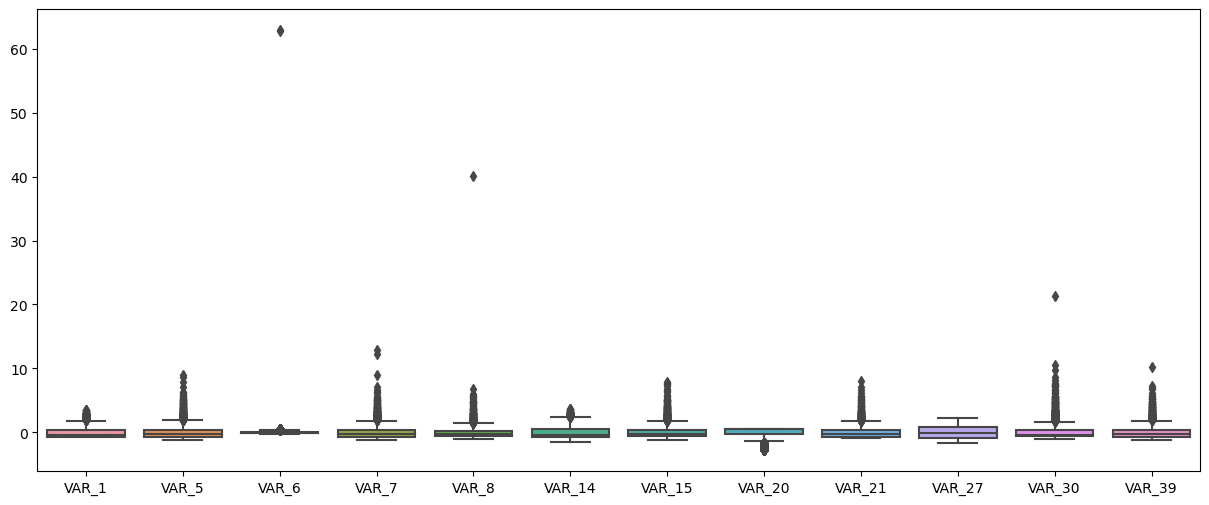

In [33]:
# Plotando o BoxPlot das variáveis
plt.figure(dpi=100, figsize=(15, 6))
sns.boxplot(data = numeric_scaled,orient="v")

In [34]:
# Percentual de outliers por coluna
for col in  selected_features:
    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    qtd = sum(((x_train_copy[col] > (q3+1.5*iqr)) | (x_train_copy[col] < (q1-1.5*iqr))))
    perc = round((qtd/x_train_copy.shape[0])*100,2)
    print(f"Percentual de outliers para {col}: {perc}%")

Percentual de outliers para VAR_1: 8.96%
Percentual de outliers para VAR_5: 3.4%
Percentual de outliers para VAR_6: 3.75%
Percentual de outliers para VAR_7: 2.97%
Percentual de outliers para VAR_8: 2.97%
Percentual de outliers para VAR_14: 1.44%
Percentual de outliers para VAR_15: 2.76%
Percentual de outliers para VAR_20: 15.0%
Percentual de outliers para VAR_21: 2.05%
Percentual de outliers para VAR_27: 0.0%
Percentual de outliers para VAR_30: 5.98%
Percentual de outliers para VAR_39: 2.58%


In [35]:
#criando um dicionário com os valores limites para substituir os outliers
outlier_limits = {}
for col in  selected_features:
    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    lower = (q1-1.5*iqr)
    upper = (q3+1.5*iqr)
    if lower < 0: lower = 0
    outlier_limits[col] = {"lower": lower, "upper": upper}
    
outlier_limits

{'VAR_1': {'lower': 0, 'upper': 127.5},
 'VAR_5': {'lower': 0, 'upper': 231.00875000000002},
 'VAR_6': {'lower': 0, 'upper': 4269.125},
 'VAR_7': {'lower': 0, 'upper': 170.93},
 'VAR_8': {'lower': 0, 'upper': 177.30625},
 'VAR_14': {'lower': 0, 'upper': 1538.5},
 'VAR_15': {'lower': 0, 'upper': 155.56},
 'VAR_20': {'lower': 7.0, 'upper': 15.0},
 'VAR_21': {'lower': 0, 'upper': 3619.75},
 'VAR_27': {'lower': 0, 'upper': 1247.75},
 'VAR_30': {'lower': 0, 'upper': 3818.2625},
 'VAR_39': {'lower': 0, 'upper': 814.5}}

### **Modelo Sem Fine Tuning**

#### **Pipelines**

In [36]:
# Criando o transformer de pré-processamento
preprocessor = ColumnTransformer(transformers=[
    ("imputer", SimpleImputer(missing_values = -1, strategy="median"), selected_features),
    ("clipper", ClipTransformer(outlier_limits), selected_features),
    ("scaler", RobustScaler(), selected_features)
])

In [37]:
# Criando o objeto de pipeline com o transformer e o modelo
lr_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LogisticRegression(class_weight="balanced", random_state=42))])

In [38]:
%%time
# Scores
lr_scores = cross_val_score(lr_pipeline, df_train.fillna(-1)[selected_features].copy(), y_train.copy(), cv=5, scoring="roc_auc")

CPU times: total: 1.53 s
Wall time: 841 ms


In [39]:
# Scores
print(lr_scores)
print(f"AUC médio: {lr_scores.mean()}")
print(f"Desvio padrão: {lr_scores.std()}")

[0.73012818 0.75207052 0.75479824 0.72489773 0.76360059]
AUC médio: 0.7450990530391682
Desvio padrão: 0.014947929650972011


In [40]:
# Treinando Modelo
lr_pipeline.fit(df_train.fillna(-1)[selected_features].copy(), y_train.copy())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(missing_values=-1,
                                                                strategy='median'),
                                                  ['VAR_1', 'VAR_5', 'VAR_6',
                                                   'VAR_7', 'VAR_8', 'VAR_14',
                                                   'VAR_15', 'VAR_20', 'VAR_21',
                                                   'VAR_27', 'VAR_30',
                                                   'VAR_39']),
                                                 ('clipper',
                                                  ClipTransformer(clip_dict={'VAR_1': {'lower': 0,
                                                                                       'upper': 127.5},
                                                                             'VAR_14': {'lower': 0,
                                                                                        'upper': 1538.5},
                                                                             'VAR_15': {...
                                                                             'VAR_8': {'lower': 0,
                                                                                       'upper': 177.30625}}),
                                                  ['VAR_1', 'VAR_5', 'VAR_6',
                                                   'VAR_7', 'VAR_8', 'VAR_14',
                                                   'VAR_15', 'VAR_20', 'VAR_21',
                                                   'VAR_27', 'VAR_30',
                                                   'VAR_39']),
                                                 ('scaler', RobustScaler(),
                                                  ['VAR_1', 'VAR_5', 'VAR_6',
                                                   'VAR_7', 'VAR_8', 'VAR_14',
                                                   'VAR_15', 'VAR_20', 'VAR_21',
                                                   'VAR_27', 'VAR_30',
                                                   'VAR_39'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

#### **Métricas Teste**

In [41]:
# Gerando previsões
y_predict = lr_pipeline.predict(df_test.fillna(-1)[selected_features].copy())

In [42]:
# Métricas gerais de classificação
print("Resultados Decision Tree:")
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

Resultados Decision Tree:
0.664424218440839
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1715
           1       0.48      0.43      0.45       812

    accuracy                           0.66      2527
   macro avg       0.61      0.60      0.60      2527
weighted avg       0.66      0.66      0.66      2527



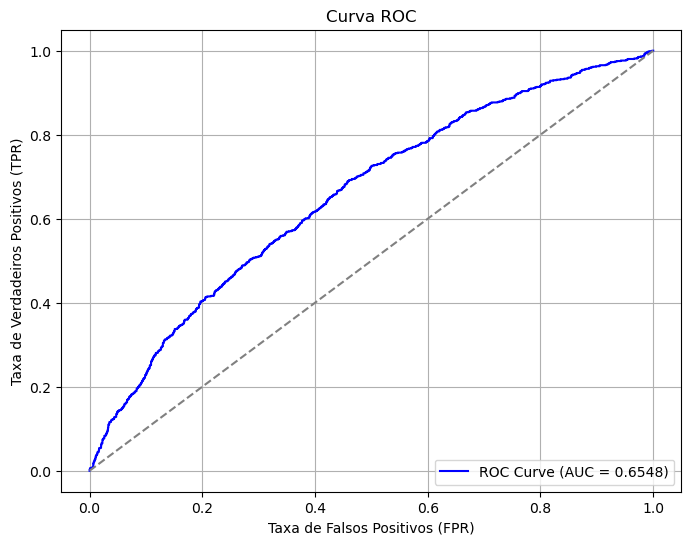

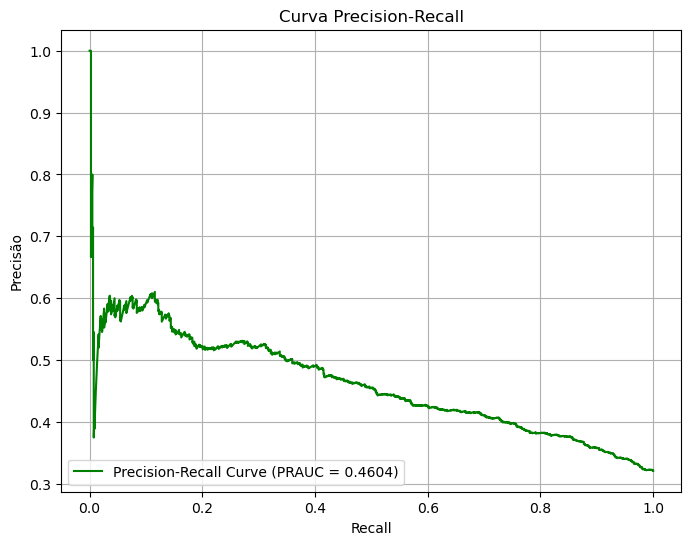

In [43]:
y_scores = lr_pipeline.predict_proba(df_test.fillna(-1)[selected_features].copy())[:, 1]

auc_score = plot_roc_curve(y_test, y_scores)
pr_auc_score = plot_precision_recall_curve(y_test, y_scores)

### **Modelo Com Fine Tuning**

#### **Pipelines**

In [44]:
# Criando o objeto de pipeline com o transformer e o modelo
lr_search_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LogisticRegression(class_weight="balanced", random_state=42))])

In [ ]:
%%time
# Definindo Grid de Parâmetros e Treinando
lr_grid = {
    "model__penalty": ["l1", "l2", "elasticnet", None],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear", "saga", "newton-cholesky"],
    "model__max_iter": [100, 200, 300, 500, 1000]
}
lr_random_search = RandomizedSearchCV(lr_search_pipeline, lr_grid, n_iter=100, cv=5, scoring="roc_auc", n_jobs=-1, random_state=42)
lr_random_search.fit(df_train.fillna(-1)[selected_features].copy(), y_train.copy())

In [ ]:
# Melhores parâmetros e performance do melhor estimator
print(lr_random_search.best_params_)
print(lr_random_search.best_score_)

#### **Métricas Teste**

In [ ]:
# Gerando previsões
y_predict = lr_random_search.predict(df_test.fillna(-1)[selected_features].copy())

In [ ]:
# Métricas gerais de classificação
print("Resultados Decision Tree:")
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

In [ ]:
y_scores_search = lr_random_search.predict_proba(df_test.fillna(-1)[selected_features].copy())[:, 1]

auc_score = plot_roc_curve(y_test, y_scores_search)
pr_auc_score = plot_precision_recall_curve(y_test, y_scores_search)

### **Variáveis Explicativas**

In [ ]:
# Obtendo os coeficientes e intercept
best_model = lr_random_search.best_estimator_["model"]
coefficients = best_model.coef_.flatten()

# Criando um DataFrame ordenado pelos valores absolutos dos coeficientes
features_coef = list(zip(coefficients, selected_features))
coef_df = pd.DataFrame({'Feature': [feature for _, feature in features_coef], 'Coefficient': [coef for coef, _ in features_coef]})
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

coef_df

### **Registros por faixa**

In [ ]:
# Arrumando Indexes
df_train = df_train.reset_index().drop(columns=["id"])
y_train = y_train.reset_index().drop(columns=["id"])

df_test = df_test.reset_index().drop(columns=["id"])
y_test = y_test.reset_index().drop(columns=["id"])

In [ ]:
df_probas = pd.DataFrame({"Prob": y_scores_search})
#df_probas[f"Faixa"] = pd.qcut(df_probas["Prob"], q=10, labels=range(10), duplicates="drop")
bins = np.linspace(0, 1, 10 + 1)  # 10 faixas de mesmo tamanho de 0 a 1
labels = [f"{i+1}" for i in range(10)]

# Aplicando pd.cut para dividir a coluna em intervalos fixos
df_probas["Faixa"] = pd.cut(df_probas["Prob"], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# Concatenando com as informações
df_probas = pd.concat([y_test, df_probas], axis=1)
df_probas = pd.concat([df_probas, df_test[selected_features]], axis=1)
df_probas

In [ ]:
# Quantidade de registros por Faixa
df_probas["Faixa"].value_counts()

In [ ]:
df_group_faixas = df_probas["Faixa"].value_counts().reset_index()
df_group_faixas.columns = ["Faixa", "registros"]
df_group_faixas = df_group_faixas.sort_values("Faixa").reset_index().drop(columns=["index"])
df_group_faixas["representatividade"] = (df_group_faixas["registros"] / df_probas.shape[0]) * 100
df_group_faixas["representativiade_acumulada"] = df_group_faixas["representatividade"].cumsum()
df_group_faixas

In [ ]:
plot_stacked_bar_chart(df_probas, "Faixa", "y")

In [ ]:
# Analisando as 3 principais variáveis
plot_mean_by_category(df_probas, "Faixa", "VAR_20")

In [ ]:
plot_mean_by_category(df_probas, "Faixa", "VAR_1")

In [ ]:
plot_mean_by_category(df_probas, "Faixa", "VAR_8")

In [ ]:
plot_mean_by_category(df_probas, "Faixa", "VAR_5")